<a href="https://colab.research.google.com/github/gnurtqh/audio_analytics/blob/master/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Аудиоаналитика
Лабораторная работа №3: ED-CNN

Студент: ХО КУАНГ ЧУНГ

**Задание:**
Изменить в коде хотя бы два (можно больше) момента, которые теоретически, должны улучшить результат. Можно выбирать из этого:
1. Частота дискретизации (вместе с этим можно попробовать увеличить количество мелов, но будет считаться за одно) Учтите, что при изменении частоты, изменится и размеры спектрограмм. Чтобы взять 2 секунды звука, нужно будет уже брать не 64 отсчета в спектрограмме.
2. Изменить количество секунд, на котором обучаемся.
3. Добавить выбор случайного кусочка звука в EventDetectionDataset в функции getitem() (это должно сделать результат гораздо лучше)
4. Изменить optimizer на Adam
5. Изменить train/val разбиение
6. Добавить новый полносвязный и/или сверточный слой в класс модели рекомендую еще увеличить количество эпох, так как моя модель, скорее всего, не доучилась
___

**Описание работы:**
1. Частота дискретизации = 16000, количество мелов = 128
2. Размер во времени = 128. Количество секунд = [(128-1)*1024/4]/16000 = 2.032 сек
3. Добавил выбор случайного кусочка звука
4. Изменил optimizer на Adam
5. Изменил train/val разбиение (4883/800 -> 5283/400)
6. Добавил новый полносвязный слой в класс модели.

## Импорт библиотек

In [140]:
import os.path as path
import zipfile
import io
from scipy.io import wavfile
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from IPython.display import Audio
import pickle
from enum import Enum
from typing import NoReturn, Optional
from tqdm import tqdm
import numpy as np
import librosa
import librosa.feature as F

## Общая инициализация

### Путь к каталогу, в котором лежит датасет
> датасет представлен файлом `train.csv` и папкой `train`

In [141]:
# from google.colab import drive
# drive.mount('/content/drive')

In [142]:
base_folder = "/content/drive/MyDrive/lab"

In [143]:
train_folder = path.join(base_folder, "train")
train_csv = path.join(base_folder, "train.csv")
train_pickle = path.join(base_folder, "train.pickle")
labels_pickle = path.join(base_folder, "labels.pickle")

## Извлечение признаков

**Функция для извлечения признаков и сохранения на диск**

In [144]:
class SetType(Enum):
    """Set type"""
    TRAIN = 1
    TEST  = 2
    DEV   = 3

def extract_log_mel_feats(set_type:SetType, path_to_csv:str, path_to_files:str,
                          out_path:str, labels_pickle:str, sr:Optional[int], n_fft:int,
                          hop_length:int, n_mels:int) -> Optional[dict[str,int]]:
    """
    Extract features from given files and store them in binary format.

    :param set_type: set tyle
    :param path_to_csv: path to loaded csv
    :param path_to_files: path to loaded data
    :param out_path: path to store extracted features
    :param labels_pickle: path to store labels dictionary
    :param sr: input files sample rate
    :param n_fft: size of fft window
    :param hop_length: hop size
    :param n_mels: number of mel band

    :return:
    """
    if set_type not in [SetType.TRAIN, SetType.TEST]:
        raise Exception(f'Such set type not supported: {set_type}')

    feats = []

    if set_type == SetType.TRAIN:
        meta = pd.read_csv(path_to_csv, skiprows=1, names=['fname', 'label'])

        file_names = list(meta['fname'])
        n_files = len(file_names)
        labels = list(meta['label'])

        uniq_labels = np.sort(np.unique(labels))
        label_to_id = {label: i for i, label in enumerate(uniq_labels)}

        print('Total files:', n_files)

        for i, (file_name, label) in tqdm(enumerate(zip(file_names, labels))):
            wav_data, sr = librosa.load(os.path.join(path_to_files, file_name), sr=sr)
            mel_spec = F.melspectrogram(
                y=wav_data,
                n_fft=n_fft,
                hop_length=hop_length,
                n_mels=n_mels,
                fmax=sr // 2
            )
            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
                'label_id': label_to_id[label]
            })

        pickle.dump(feats, open(out_path, 'wb'))
        pickle.dump(label_to_id, open(labels_pickle, 'wb'))
        return label_to_id
    else:
        for i, file_name in tqdm(enumerate(os.listdir(path_to_files))):
            wav_data, sr = librosa.load(os.path.join(path_to_files, file_name), sr=sr)
            if len(wav_data) == 0:
                wav_data = np.zeros(sr)
            mel_spec = F.melspectrogram(
                y=wav_data,
                n_fft=n_fft,
                hop_length=hop_length,
                n_mels=n_mels,
                fmax=sr // 2
            )
            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
            })

        pickle.dump(feats, open(out_path, 'wb'))
        return

**Параметры извлечения признаков**

In [145]:
sample_rate = 16000
n_fft = 1024
overlap = 4
hop_length = n_fft // overlap
n_mels = 128

**Извлечение и сохранение признаков**

In [146]:
# label_to_id = extract_log_mel_feats(
#     SetType.TRAIN,
#     train_csv, 
#     train_folder, 
#     train_pickle,
#     labels_pickle,
#     sample_rate, 
#     n_fft, 
#     hop_length, 
#     n_mels
# )

# id_to_label = [label for label, i in label_to_id.items()]

## Алгоритм детектирования

### Подготовительный этап

In [147]:
from typing import NoReturn
from pprint import pprint
import copy
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
from sklearn.metrics import accuracy_score

In [148]:
device = device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [149]:
cpu_count = os.cpu_count()
num_workers = cpu_count if device == "cpu" else 0
num_workers, cpu_count

(0, 2)

**Добиваемся максимальной воспроизводимости**

Согласно данному мануалу: https://pytorch.org/docs/stable/notes/randomness.html

In [150]:
def set_random_state(random_state:int=0) -> NoReturn:
    """Initialize random generators.

    Parameters
    ==========
    random_state : int = 0
        Determines random number generation for centroid initialization.
        Use an int to make the randomness deterministic.
    """
    torch.manual_seed(random_state)
    random.seed(random_state)
    np.random.seed(random_state)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_state)
        torch.cuda.manual_seed(random_state)

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [151]:
random_state = 42

In [152]:
torch.use_deterministic_algorithms(True)

In [153]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8
%env PYTHONHASHSEED=42

env: CUBLAS_WORKSPACE_CONFIG=:4096:8
env: PYTHONHASHSEED=42


### Архитектура нейронной сети

In [154]:
class DummyNetwork(nn.Module):
    """Neural network base architecture"""
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,  out_channels=64, kernel_size=5, stride=(2, 2), device=device)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=(1, 1), device=device)
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=(1, 1), device=device)

        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.3)
        self.dropout4 = nn.Dropout(p=0.3)
        
        self.bn1 = nn.BatchNorm2d(num_features=64, device=device)
        self.bn2 = nn.BatchNorm2d(num_features=96, device=device)
        self.bn3 = nn.BatchNorm2d(num_features=64, device=device)
        self.bn4 = nn.BatchNorm1d(num_features=2048, device=device)

        self.flat = nn.Flatten()

        # 33856 - должно соответствовать форме self.flat
        self.fc1 = nn.Linear(193600, 2048, device=device)
        self.fc2 = nn.Linear(2048, 41, device=device)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout3(x)

        x = self.flat(x)

        # здесь можно еще добавить полносвязный слой или слои
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.dropout4(x)

        x = self.fc2(x)

        return x

### Обучение нейронной сети

**Загрузка ранее извлеченных признаков и подготовка данных для обучения**

In [155]:
train_data = pickle.load(open(train_pickle, "rb"))
label_to_id = pickle.load(open(labels_pickle, "rb"))
id_to_label = [label for label, i in label_to_id.items()]

**Разделение набора данных на обучение и проверку**

In [156]:
validation_set_size = 400

x_val = []
y_val = []

x_tr = []
y_tr = []

for i, row in enumerate(train_data):
    feature = row['feature']
    if i < validation_set_size:
        x_val.append(feature)
        y_val.append(row['label_id'])
    else:
        x_tr.append(feature)
        y_tr.append(row['label_id'])

**Создание класса для набора данных**

In [157]:
class EventDetectionDataset(Dataset):
    def __init__(self, x, y=None, device="cpu"):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = self.prepare_shape(self.x[idx])
        if self.y is not None:
            return \
                torch.tensor(x, device=device),\
                torch.tensor(self.y[idx], device=device)

        return torch.tensor(x, device=device)
    def prepare_shape(self, feature_):
        N = 128
        feature = copy.deepcopy(feature_)
        if feature.shape[1] >= N:
            start_idx = np.random.randint(0, feature.shape[1] - N + 1)
            feature = feature[:, start_idx:start_idx + N]
        else:
            while feature.shape[1] < N:
                feature = np.hstack((feature, feature))
            feature = feature[:, :N]
        return feature[np.newaxis, :, :]

In [158]:
train_dset = EventDetectionDataset(x_tr, y_tr, device=device)
val_dset = EventDetectionDataset(x_val, y_val, device=device)

In [160]:
train_loader = DataLoader(train_dset, batch_size=41, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dset, batch_size=41, shuffle=False, num_workers=num_workers)

**Обучение и проверка точности на наборе данных**

In [161]:
start_time = time.time()

n_epoch = 50

set_random_state(random_state)

criterion = nn.CrossEntropyLoss()
network = DummyNetwork()

# можно попробовать другой optimizer, тоже считается улучшением
optimizer = optim.Adam(network.parameters(), lr=0.001)

train_loss = []
val_loss = []

train_acc = []
val_acc = []

for e in range(n_epoch):
    print(f'epoch #{e+1}')

    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x)
        outputs.append(output.argmax(axis=1))

        target = y
        targets.append(target)

        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()

    y_true = torch.hstack(targets).numpy(force=True)
    y_pred = torch.hstack(outputs).numpy(force=True)
    acc = accuracy_score(y_true, y_pred)

    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)

    print(f'[train] mean loss: {train_loss[-1]}')
    print(f'[train] accuracy:  {acc}')

    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched
            #optimizer.zero_grad()

            output = network(x)
            outputs.append(output.argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())

        y_true = torch.hstack(targets).numpy(force=True)
        y_pred = torch.hstack(outputs).numpy(force=True)
        acc = accuracy_score(y_true, y_pred)

        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        
        print(f'[val] mean loss:   {val_loss[-1]}')
        print(f'[val] accuracy:    {acc}', end="\n\n")

print(f"Execution time: {(time.time() - start_time):.2f} seconds")

epoch #1
[train] mean loss: 3.326466216597446
[train] accuracy:  0.18057921635434412
[val] mean loss:   2.8183993220329286
[val] accuracy:    0.255

epoch #2
[train] mean loss: 2.5598703779915506
[train] accuracy:  0.35188339958356996
[val] mean loss:   2.2746012210845947
[val] accuracy:    0.365

epoch #3
[train] mean loss: 2.190021827239399
[train] accuracy:  0.4272193829263676
[val] mean loss:   2.012108933925629
[val] accuracy:    0.455

epoch #4
[train] mean loss: 1.991761711216712
[train] accuracy:  0.47832670830967255
[val] mean loss:   1.9151445508003235
[val] accuracy:    0.49

epoch #5
[train] mean loss: 1.8237345652986867
[train] accuracy:  0.5209161461290933
[val] mean loss:   1.8970692038536072
[val] accuracy:    0.54

epoch #6
[train] mean loss: 1.6500400960907455
[train] accuracy:  0.5595305697520349
[val] mean loss:   1.86907217502594
[val] accuracy:    0.4975

epoch #7
[train] mean loss: 1.562042285305585
[train] accuracy:  0.5911413969335605
[val] mean loss:   1.74376

**Визуализация процесса обучения сети**

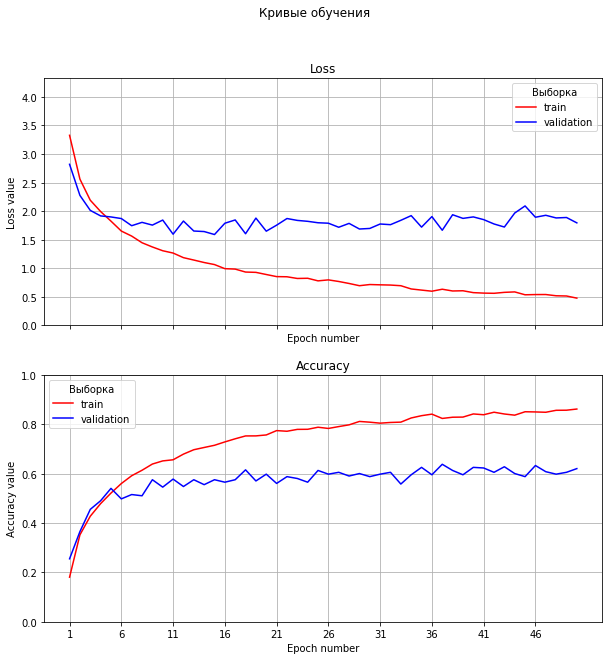

In [162]:
epochs = range(1, n_epoch+1)

fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

xticks = range(1, n_epoch+1, n_epoch // 10) if n_epoch > 10 else epochs

# draw loss
ax_top.plot(epochs, train_loss, 'r', label='train')
ax_top.plot(epochs, val_loss, 'b', label='validation')

ax_top.set(
    title='Loss',
    xlabel='Epoch number',
    ylabel='Loss value',
    ylim=[0, max(max(train_loss), max(val_loss)) + 1],
)
ax_top.legend(
    title="Выборка",
)
ax_top.grid()

# draw accuracy
ax_bottom.plot(epochs, train_acc, 'r', label='train')
ax_bottom.plot(epochs, val_acc, 'b', label='validation')

ax_bottom.set(
    title='Accuracy',
    xlabel='Epoch number',
    ylabel='Accuracy value',
    xticks=xticks,
    ylim=[0, 1],
)
ax_bottom.legend(
    title="Выборка",
)
ax_bottom.grid()

fig.suptitle("Кривые обучения")

plt.show()